### Plots of output generation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

#CASES = ["base", "cap25", "cap50", "floatingCap50", "cables50", "opex50", "base_noHydro", "cap50_noHydro"]
#CASES = ["base", "cap10", "cap20", "cap50", "cables_base", "cables_cap10", "cables_cap20", "cables_cap50"]
CASES = ["base", "cables20", "cablesHub20", "cap20", "cap50", "radial", "radial_NO"]

DF_BY_CASES = dict({})

for case in CASES:
    #_df = pd.read_csv(f'output_gen/new_{case}_results_output_gen.csv')
    _df = pd.read_csv(f'new_longer_dist_{case}/results_output_gen.csv')
    DF_BY_CASES[case] = _df

DF_BY_CASES

{'base':           Node         GeneratorType     Period  genInvCap_MW  \
 0      BosniaH      Liginiteexisting  2020-2025      0.000000   
 1      BosniaH      Liginiteexisting  2025-2030      0.000000   
 2      BosniaH      Liginiteexisting  2030-2035      0.000000   
 3      BosniaH      Liginiteexisting  2035-2040      0.000000   
 4      BosniaH      Liginiteexisting  2040-2045      0.000000   
 ...        ...                   ...        ...           ...   
 5835  SørvestD  Windoffshorefloating  2035-2040      0.000008   
 5836  SørvestD  Windoffshorefloating  2040-2045      0.000400   
 5837  SørvestD  Windoffshorefloating  2045-2050      0.002592   
 5838  SørvestD  Windoffshorefloating  2050-2055      0.000123   
 5839  SørvestD  Windoffshorefloating  2055-2060      0.003181   
 
       genInstalledCap_MW  genExpectedCapacityFactor  \
 0            1888.000000               7.499999e-01   
 1            1161.846154               7.203815e-01   
 2             780.615385     

In [2]:
# Hydrogen types handled externally
HYDROGEN_TYPES = ["HydrogenCCGT", "HydrogenOCGT"]

def plot_gen_by_source(case, _df):
    df_gen_source = _df.copy()
    df_gen_source = df_gen_source[~df_gen_source["GeneratorType"].isin(HYDROGEN_TYPES)]
    df_gen_source["genInstalledCap_MW"] = df_gen_source.groupby(['GeneratorType', 'Period'])['genInstalledCap_MW'].transform('sum')
    df_gen_source = df_gen_source.drop_duplicates(("GeneratorType", "Period"), ignore_index=True)[["GeneratorType", "Period", "genInstalledCap_MW"]]

    periods = list(df_gen_source["Period"].unique())

    gen_source_sorted_by_cap = list(df_gen_source[df_gen_source["Period"] == "2055-2060"]\
                              .sort_values(by="genInstalledCap_MW", ascending=False)["GeneratorType"].values)
    
    gen_source_displayed = gen_source_sorted_by_cap

    installed_caps_gen = []
    for gen_source in gen_source_displayed:
        cap_by_period = []
        for period in periods:
            cap_by_period.append(df_gen_source[(df_gen_source["GeneratorType"] == gen_source) & (df_gen_source["Period"] == period)]["genInstalledCap_MW"].values[0])

        # Remove gen_source that have no capacity (1 MW since some threshold)
        if all(c < 1 for c in cap_by_period):
            gen_source_displayed.remove(gen_source)
        else:
            installed_caps_gen.append(cap_by_period)

    installed_caps_gen_TW = [[cap/1000000 for cap in sublist] for sublist in installed_caps_gen]
    period_displayed_gen = [period.split("-")[1] for period in periods]

    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.prop_cycle'] = cycler('color', [*plt.get_cmap('tab20c').colors, *plt.get_cmap('tab20b').colors])
    plt.figure(figsize=(10,6))
    plt.rc('axes', axisbelow=True)
    plt.grid()
    plt.stackplot(period_displayed_gen, installed_caps_gen_TW, labels=gen_source_displayed)
    plt.ylabel('Generator capacity [TW]')
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=5)
    plt.margins(x=0)
    plt.title(f"Generation by source for case: {case}")
    plt.show()

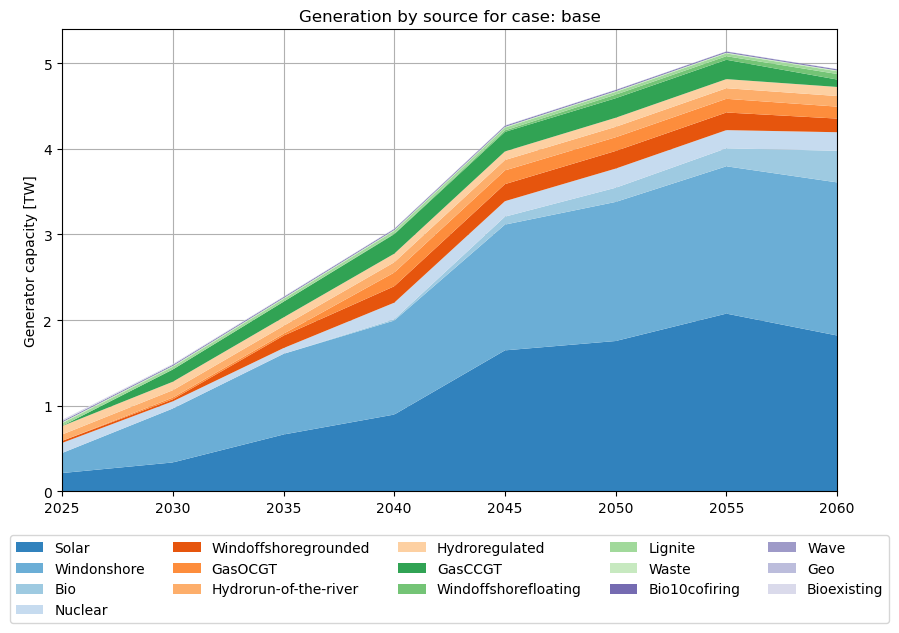

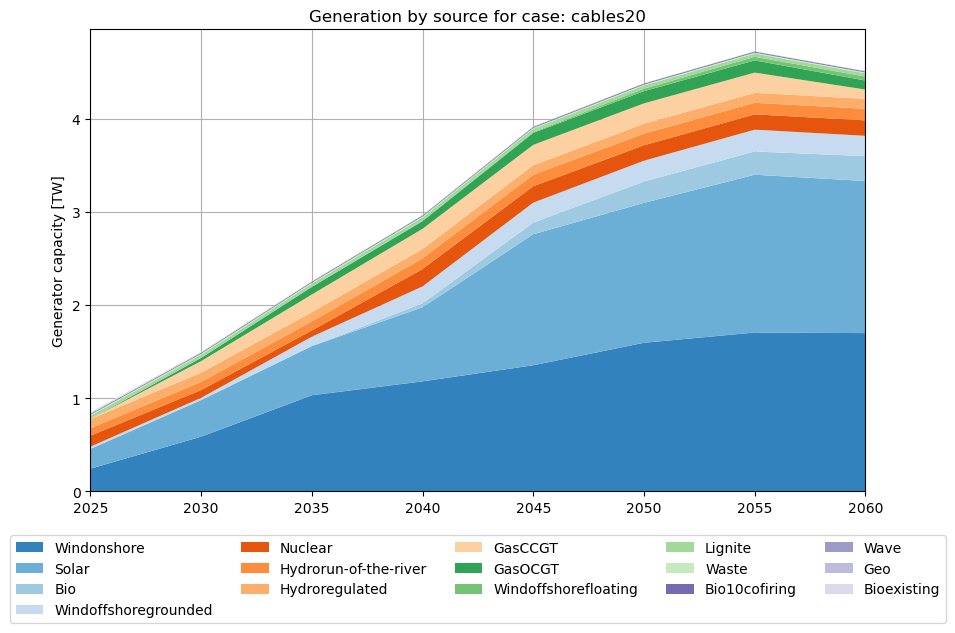

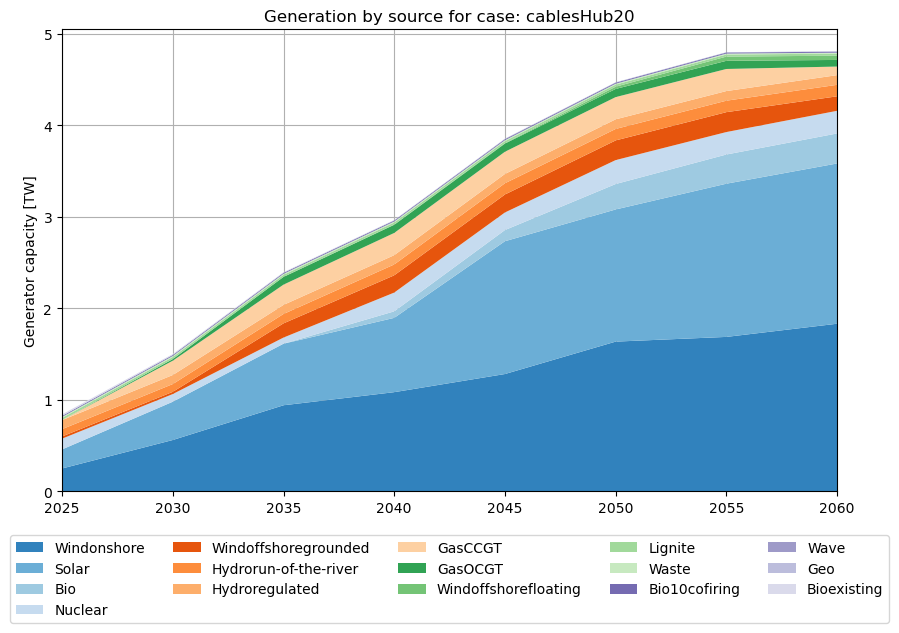

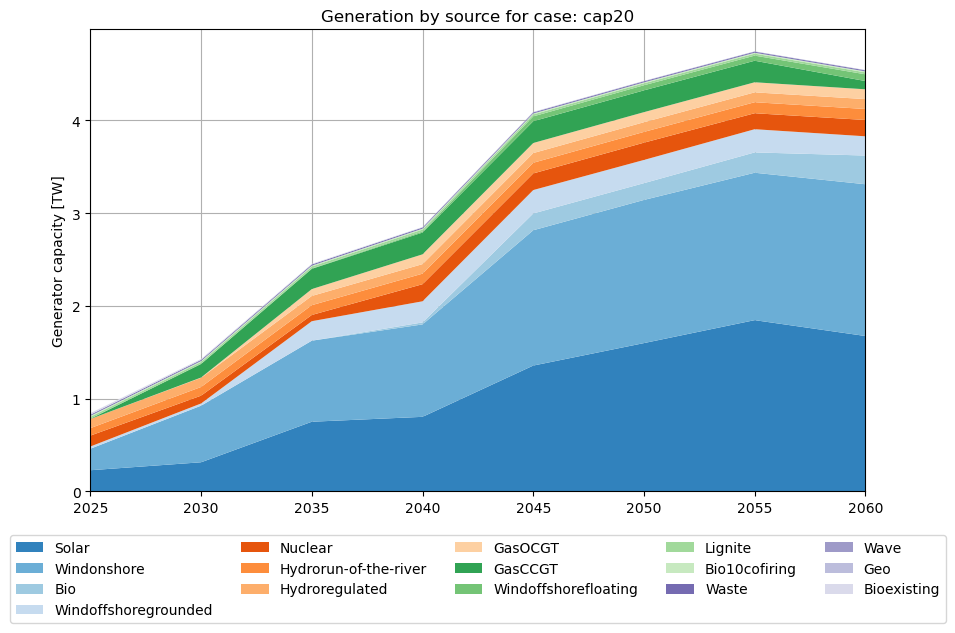

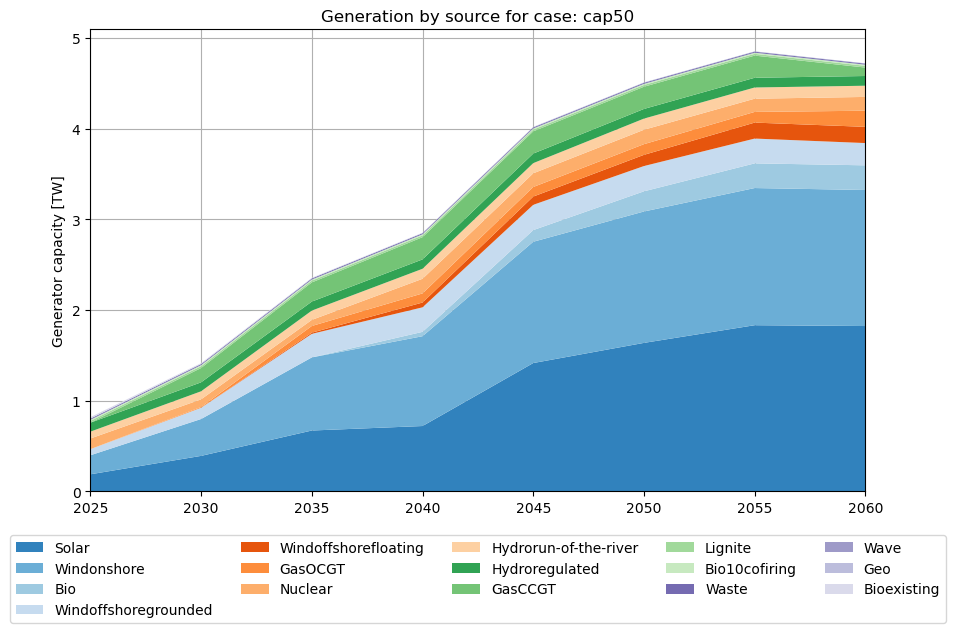

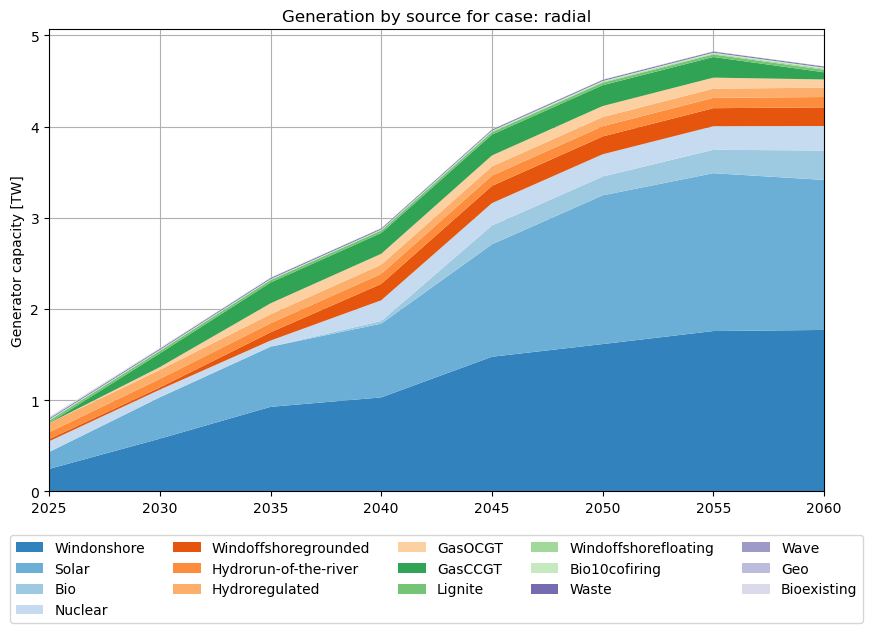

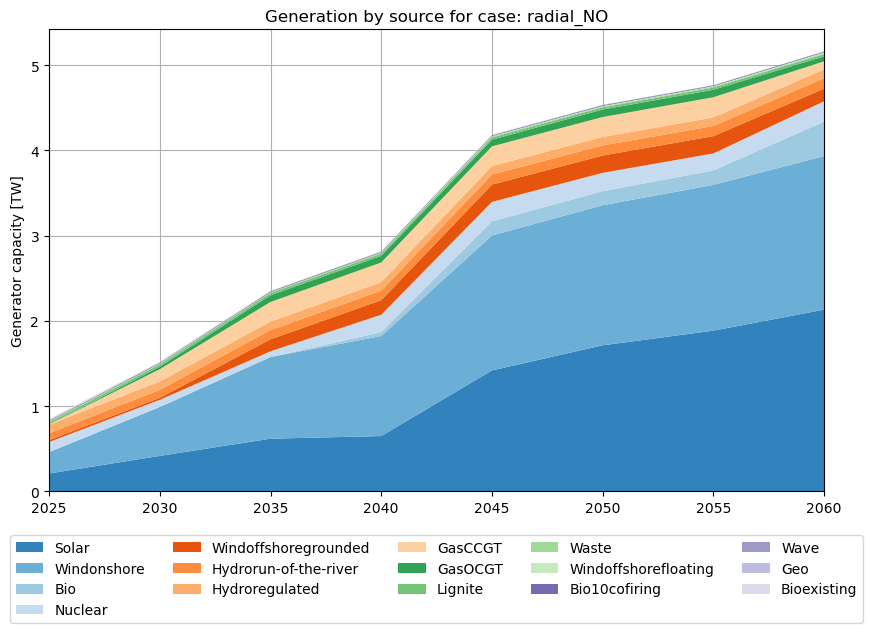

In [3]:
for case, _df in DF_BY_CASES.items():
    plot_gen_by_source(case, _df)

#### By wind farm nodes (combined floating + grounded tech)

In [4]:
WIND_FARM_NODES = ["Moray Firth","Firth of Forth","Dogger Bank",
                     "Hornsea","Outer Dowsing","Norfolk","East Anglia",
                     "Borssele","Hollandsee Kust","Helgoländer Bucht",
                     "Nordsøen",'Nordvest A', 'Nordvest C', 'Vestavind A', 
                     'Sønnavind A', 'Sørvest C', 'Nordvest B', 'Vestavind F', 
                     'Sørvest E', 'Sørvest A', 'Vestavind B', 'Vestavind C',
                     'Vestavind D', 'Sørvest F', 'Sørvest B', 'Nordavind B', 
                     'Nordavind A', 'Nordavind D', 'Nordavind C', 'Vestavind E', 'Sørvest D']

WIND_FARM_NODES = [node.replace(" ", "") for node in WIND_FARM_NODES]

NO_NODES = ['Nordvest A', 'Nordvest C', 'Vestavind A', 
                     'Sønnavind A', 'Sørvest C', 'Nordvest B', 'Vestavind F', 
                     'Sørvest E', 'Sørvest A', 'Vestavind B', 'Vestavind C',
                     'Vestavind D', 'Sørvest F', 'Sørvest B', 'Nordavind B', 
                     'Nordavind A', 'Nordavind D', 'Nordavind C', 'Vestavind E', 'Sørvest D']

NO_NODES = [node.replace(" ", "") for node in NO_NODES]

def plot_wind_prod(case, _df):
    df_wind_farm_nodes = _df[_df['Node'].isin(WIND_FARM_NODES)]

    # Sum floating + grounded cap
    df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')
    df_wind_farm_nodes = df_wind_farm_nodes.drop_duplicates(("Node", "Period"), ignore_index=True)[["Node", "Period", "genInstalledCap_MW"]]
    
    df_NO_nodes = df_wind_farm_nodes[df_wind_farm_nodes["Node"].isin(NO_NODES)]
    prod_NO_2050 = df_NO_nodes[df_NO_nodes["Period"] == "2045-2050"]["genInstalledCap_MW"].sum()

    print(f"NO prod in 2050: {round(prod_NO_2050/1000, 1)} GW")

    periods = list(df_wind_farm_nodes["Period"].unique())
    nodes_sorted_by_cap = list(df_wind_farm_nodes[df_wind_farm_nodes["Period"] == "2055-2060"].sort_values(by="genInstalledCap_MW", ascending=False)["Node"].values)

    nodes_displayed = nodes_sorted_by_cap

    installed_caps = []
    for node in nodes_displayed:
        cap_by_period = []
        for period in periods:
            cap_by_period.append(df_wind_farm_nodes[(df_wind_farm_nodes["Node"] == node) & (df_wind_farm_nodes["Period"] == period)]["genInstalledCap_MW"].values[0])

        # Remove nodes that have no capacity (1 MW since some threshold)
        if all(c < 1 for c in cap_by_period):
            nodes_displayed.remove(node)
        else:
            installed_caps.append(cap_by_period)

    installed_caps_GW = [[cap/1000 for cap in sublist] for sublist in installed_caps]
    period_displayed = [period.split("-")[1] for period in periods]

    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.prop_cycle'] = cycler('color', [*plt.get_cmap('tab20c').colors, *plt.get_cmap('tab20b').colors])
    plt.figure(figsize=(10,8))
    plt.rc('axes', axisbelow=True)
    plt.grid()
    plt.stackplot(period_displayed, installed_caps_GW, labels=nodes_displayed)
    plt.ylabel('Wind power capacity [GW]')
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=5)
    plt.margins(x=0)
    plt.title(f"Wind production (floating + grounded) by area for case: {case}")
    plt.show()

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 46.6 GW


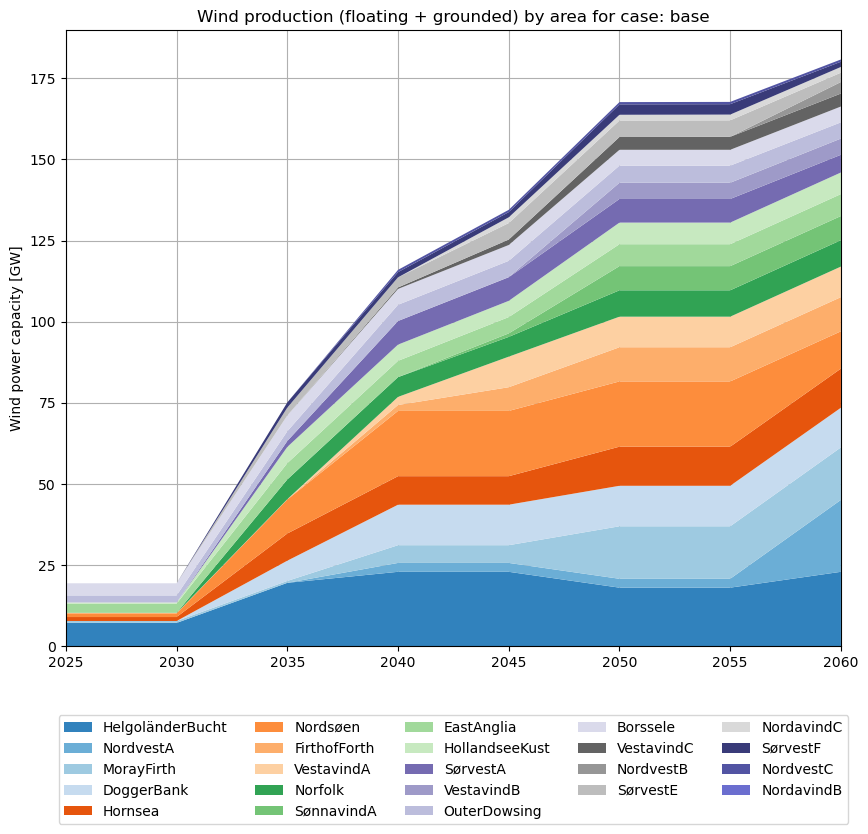

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 53.2 GW


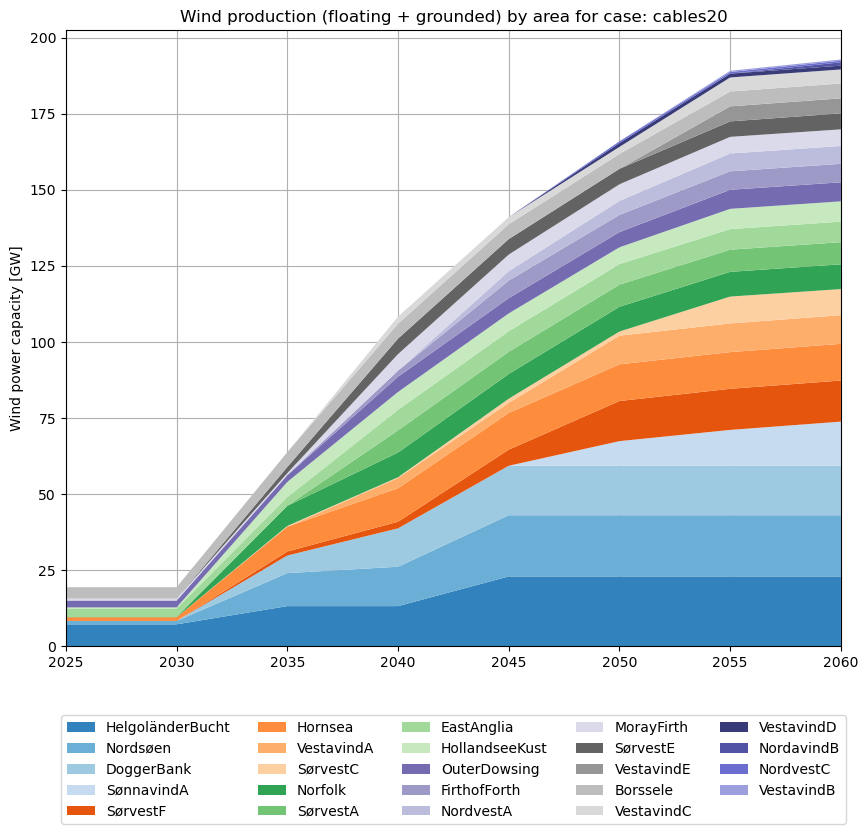

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 39.5 GW


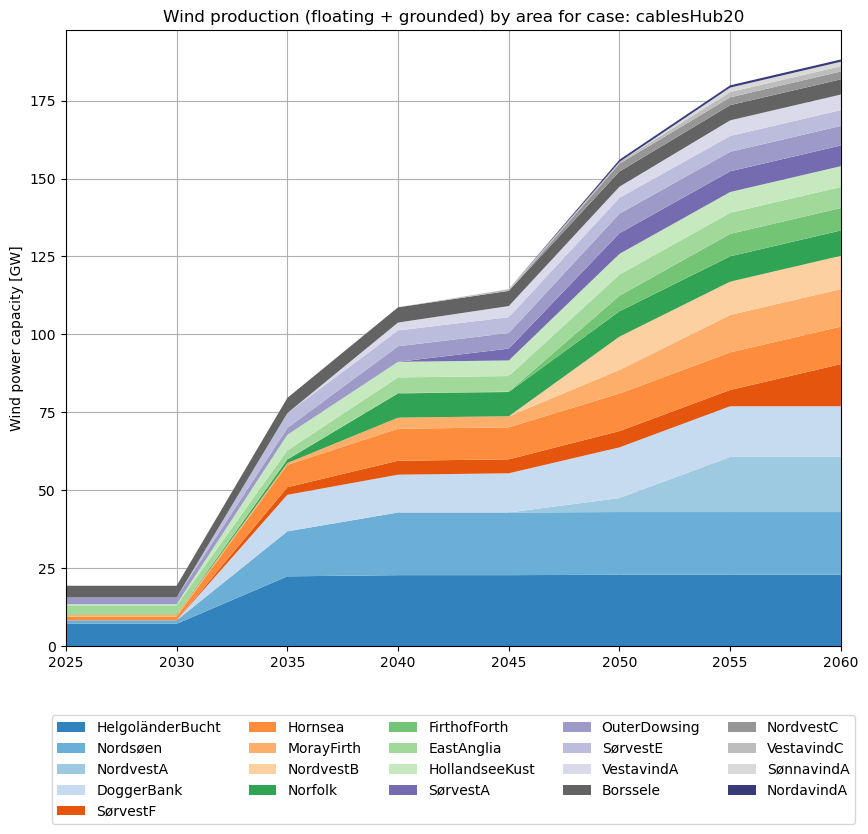

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 85.9 GW


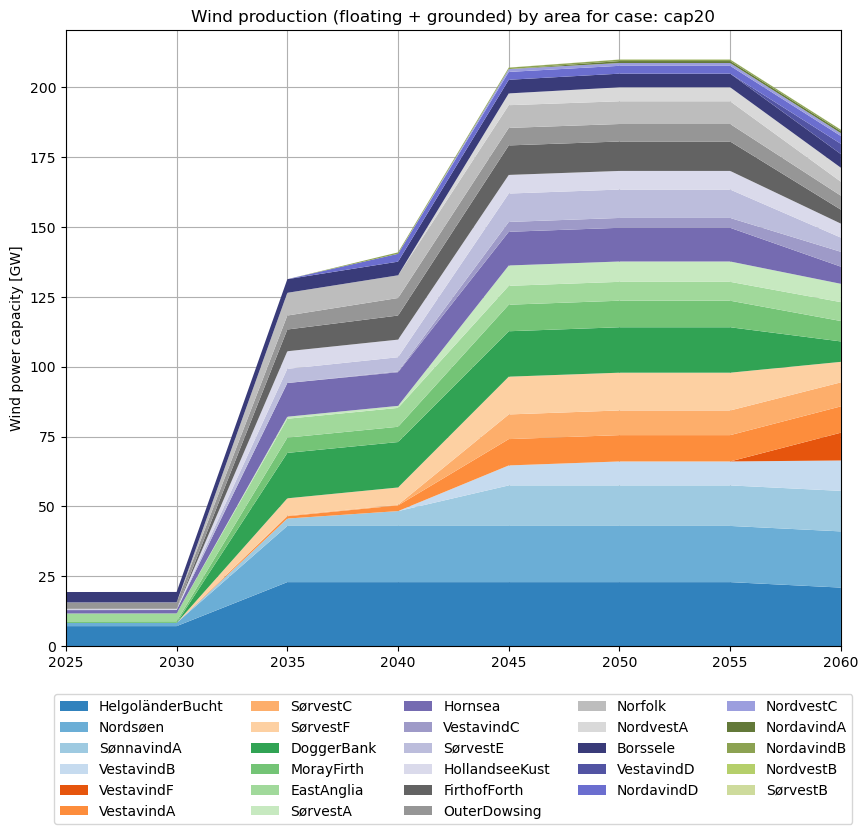

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 156.8 GW


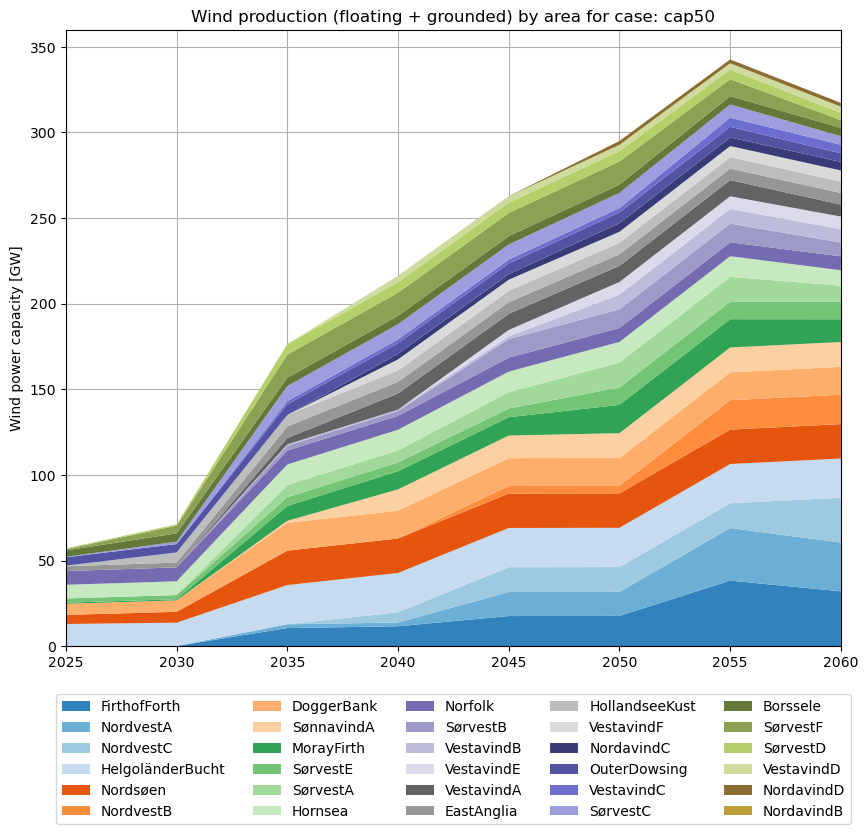

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 9.2 GW


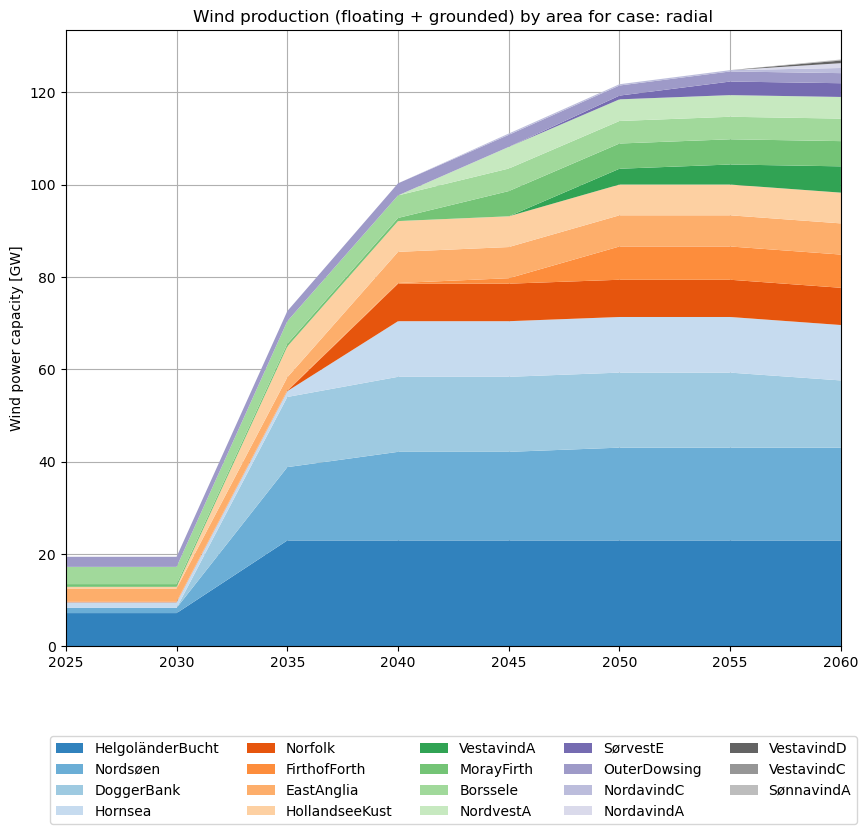

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/565295212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 8.4 GW


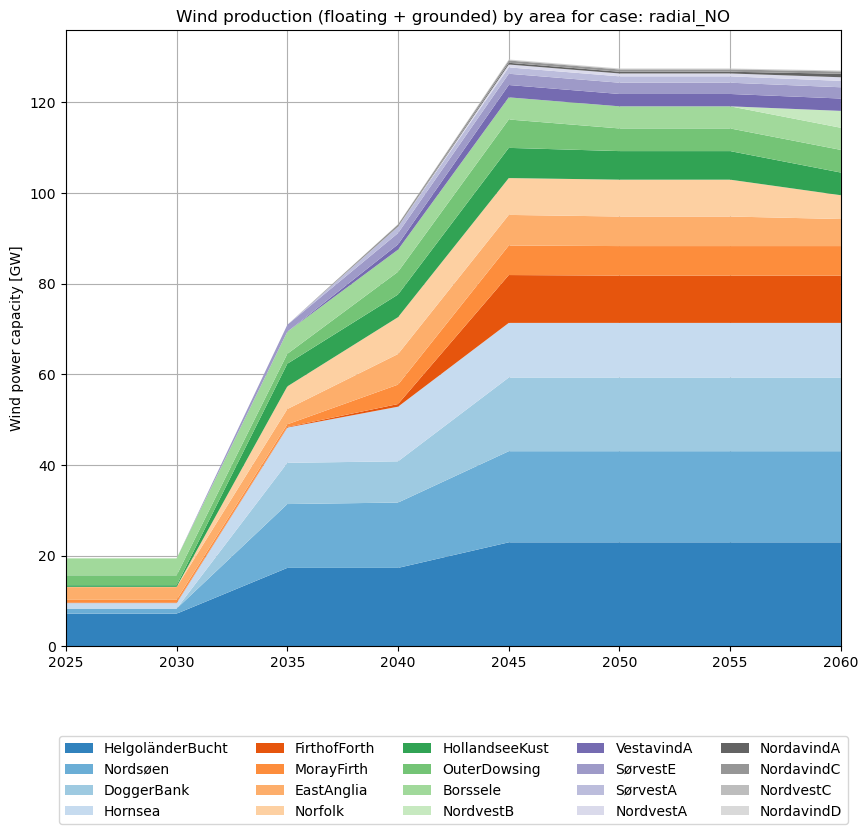

In [5]:
for case, _df in DF_BY_CASES.items():
    plot_wind_prod(case, _df)

#### By NO wind farm nodes

In [7]:
def plot_wind_prod_NO(case, _df):
    df_wind_farm_nodes = _df[_df['Node'].isin(NO_NODES)]

    # Sum floating + grounded cap
    df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')
    df_wind_farm_nodes = df_wind_farm_nodes.drop_duplicates(("Node", "Period"), ignore_index=True)[["Node", "Period", "genInstalledCap_MW"]]
    
    prod_NO_2050 = df_wind_farm_nodes[df_wind_farm_nodes["Period"] == "2045-2050"]["genInstalledCap_MW"].sum()

    print(f"NO prod in 2050: {round(prod_NO_2050/1000, 1)} GW")

    periods = list(df_wind_farm_nodes["Period"].unique())
    nodes_sorted_by_cap = list(df_wind_farm_nodes[df_wind_farm_nodes["Period"] == "2055-2060"].sort_values(by="genInstalledCap_MW", ascending=False)["Node"].values)

    nodes_displayed = nodes_sorted_by_cap

    installed_caps = []
    for node in nodes_displayed:
        cap_by_period = []
        for period in periods:
            cap_by_period.append(df_wind_farm_nodes[(df_wind_farm_nodes["Node"] == node) & (df_wind_farm_nodes["Period"] == period)]["genInstalledCap_MW"].values[0])

        # Remove nodes that have no capacity (1 MW since some threshold)
        if all(c < 1 for c in cap_by_period):
            nodes_displayed.remove(node)
        else:
            installed_caps.append(cap_by_period)

    installed_caps_GW = [[cap/1000 for cap in sublist] for sublist in installed_caps]
    period_displayed = [period.split("-")[1] for period in periods]

    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.prop_cycle'] = cycler('color', [*plt.get_cmap('tab20c').colors, *plt.get_cmap('tab20b').colors])
    plt.figure(figsize=(10,8))
    plt.rc('axes', axisbelow=True)
    plt.grid()
    plt.stackplot(period_displayed, installed_caps_GW, labels=nodes_displayed)
    plt.ylabel('Wind power capacity [GW]')
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=5)
    plt.margins(x=0)
    plt.title(f"Wind production (floating + grounded) for NO areas for case: {case}")
    plt.show()

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 46.6 GW


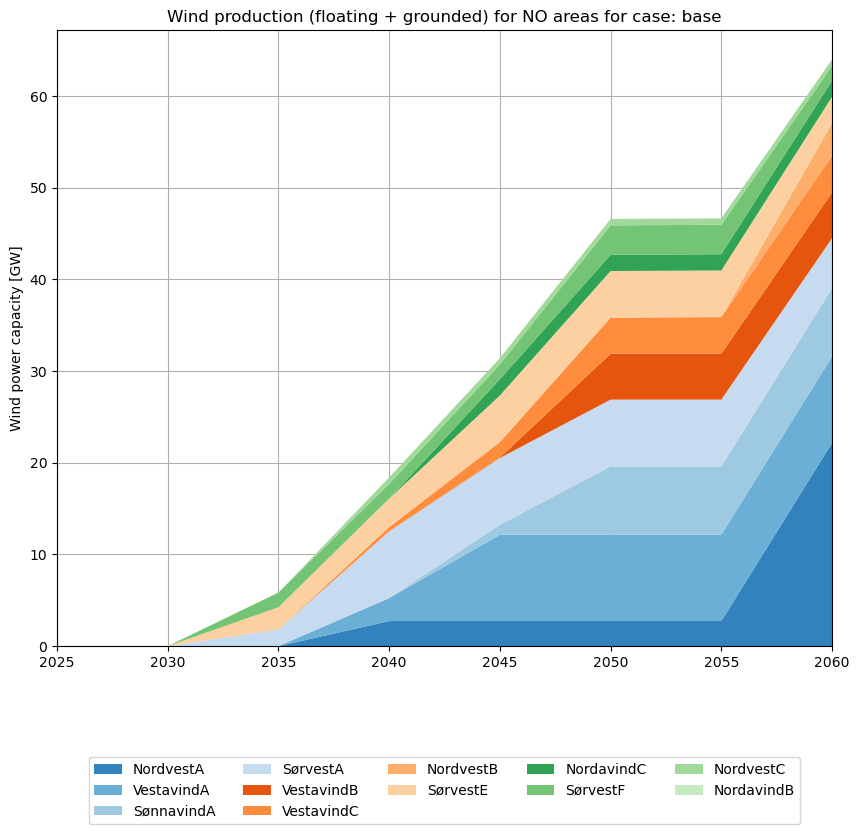

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 53.2 GW


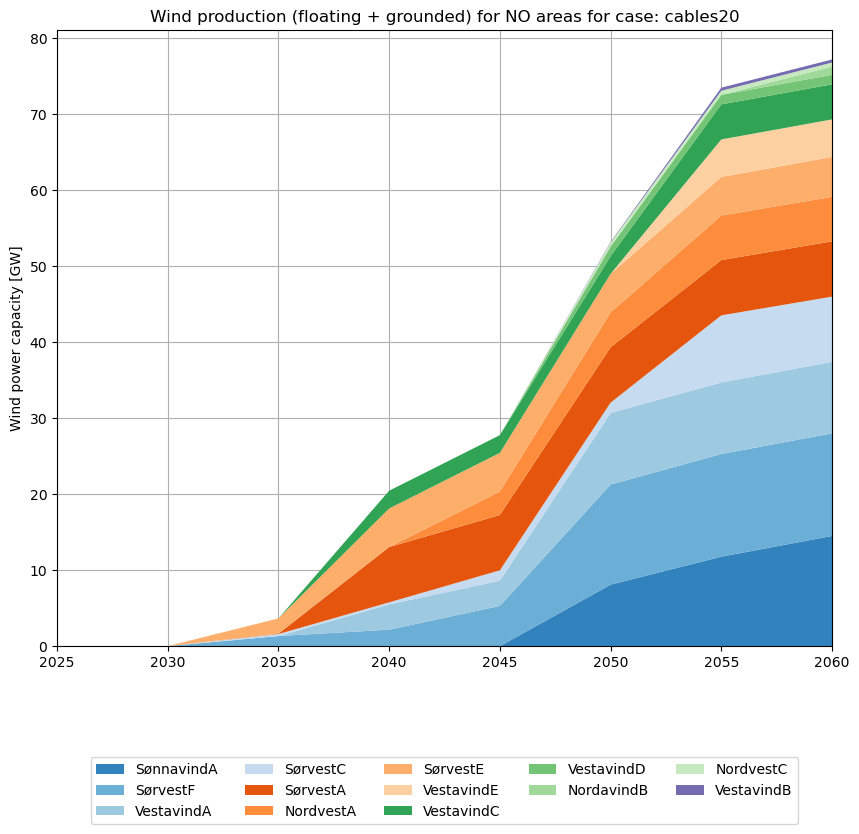

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 39.5 GW


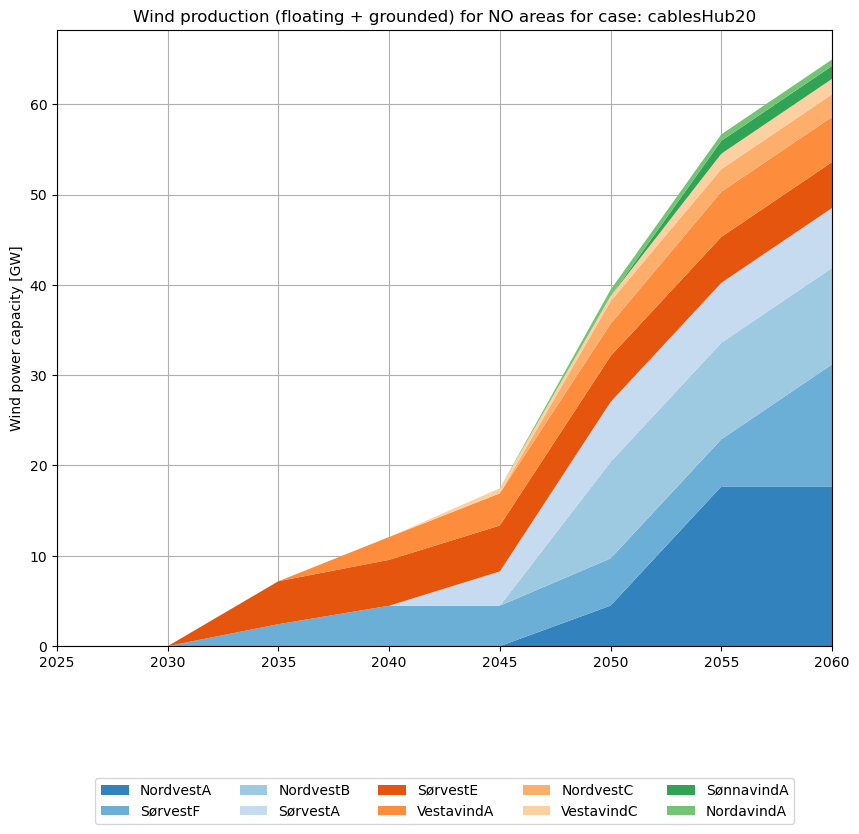

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 85.9 GW


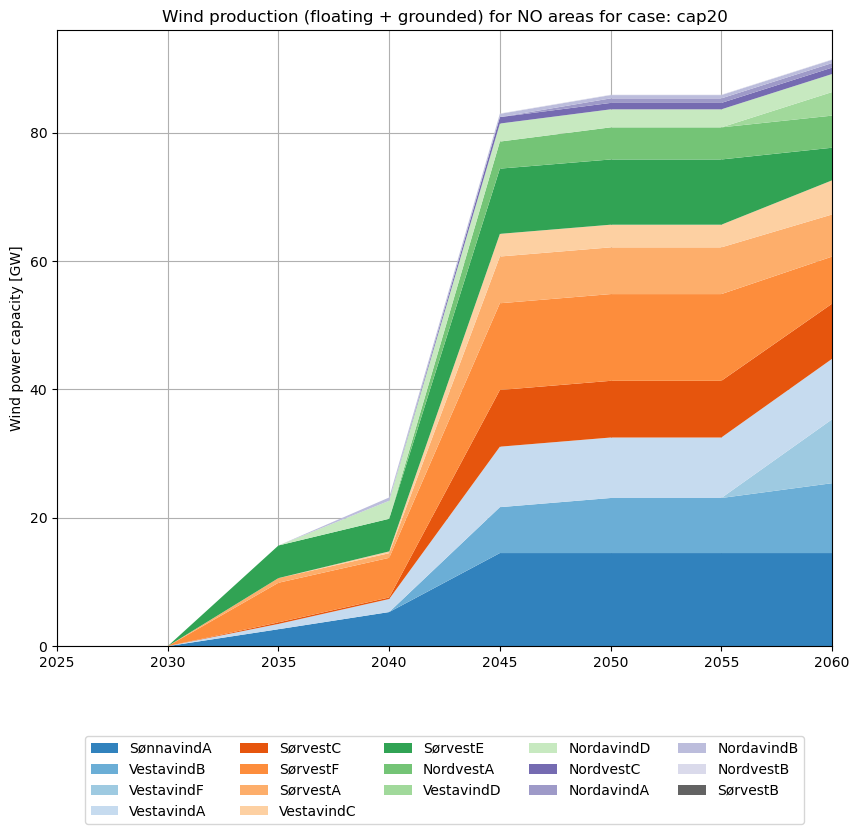

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 156.8 GW


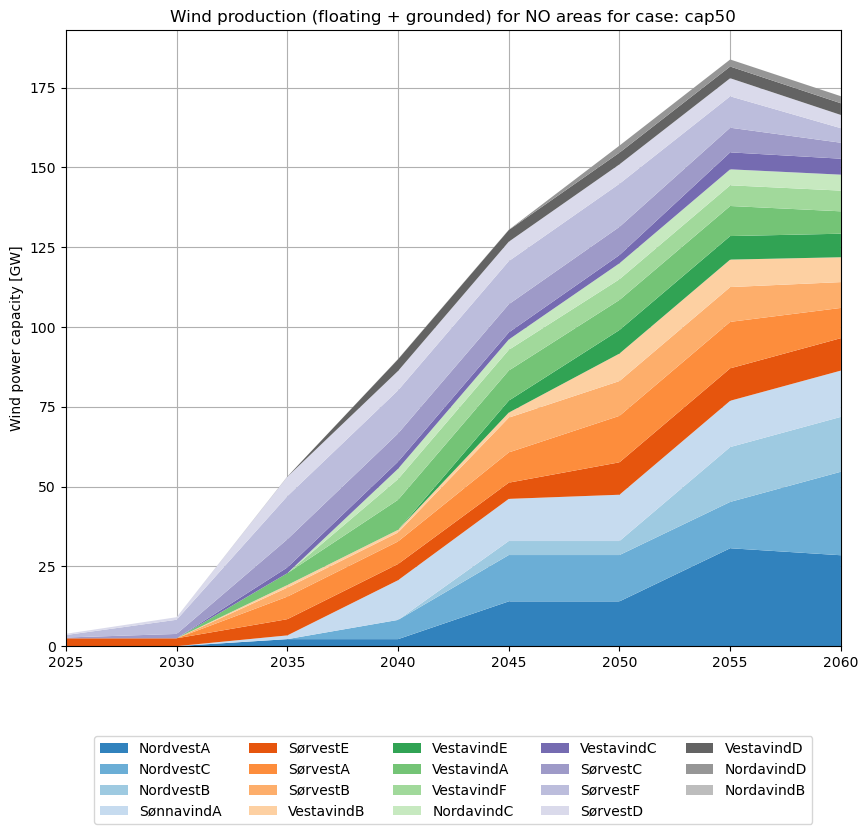

NO prod in 2050: 9.2 GW


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


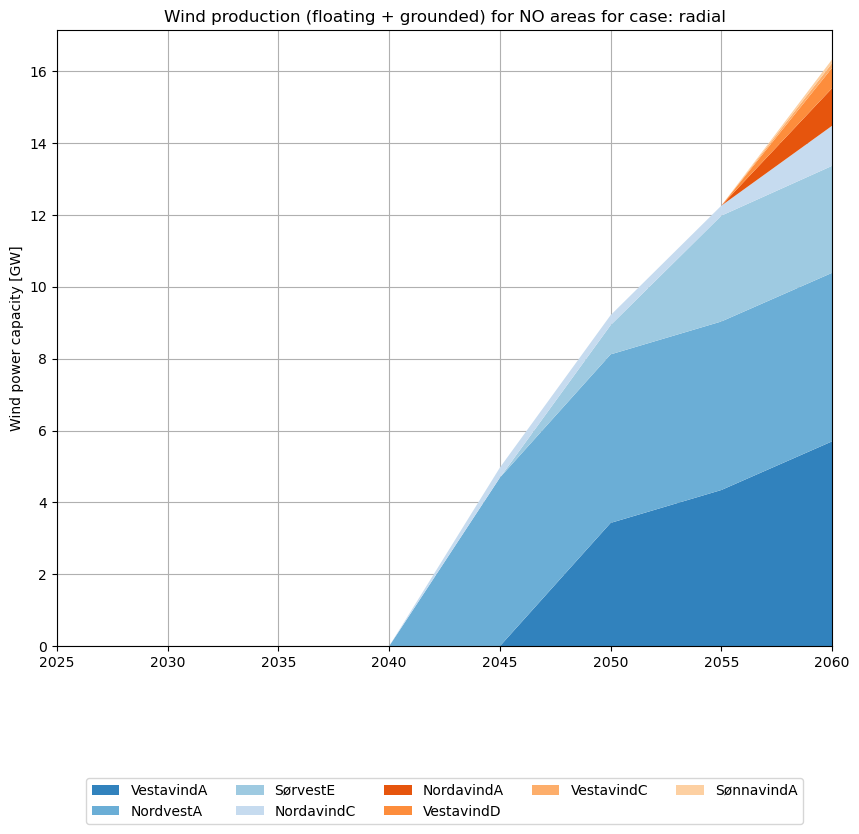

/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_29166/283848749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


NO prod in 2050: 8.4 GW


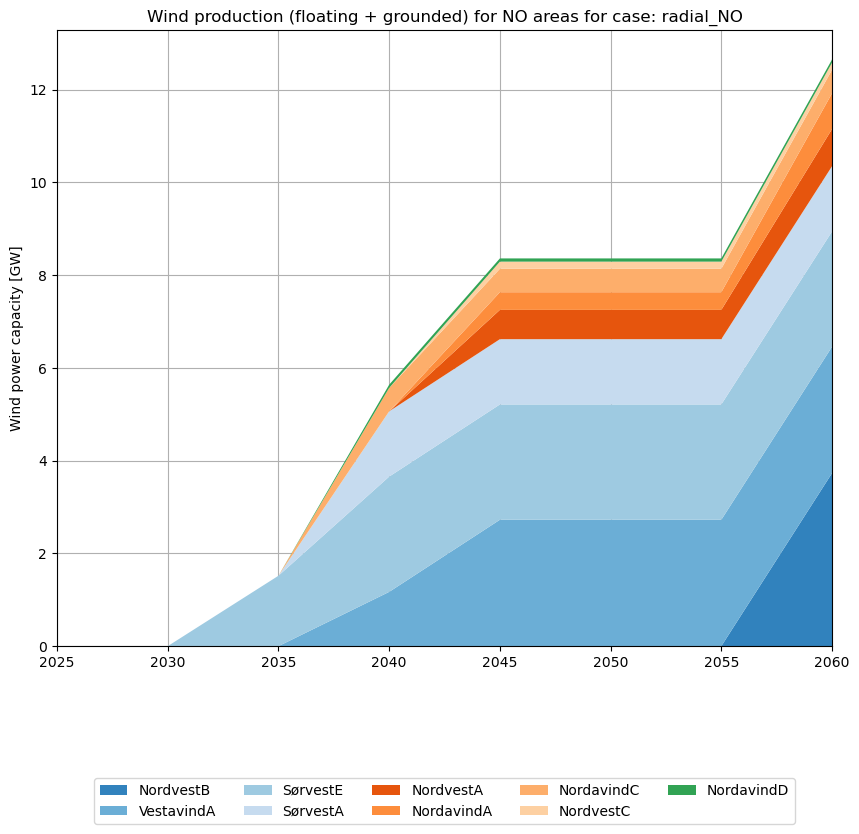

In [8]:
for case, _df in DF_BY_CASES.items():
    plot_wind_prod_NO(case, _df)